__mlmachine - GroupbyImputer, KFoldEncoder, and Skew Correction__
<br><br>
Welcome to Example Notebook 2. If you're new to mlmachine, check out [Example Notebook 1](https://github.com/petersontylerd/mlmachine/blob/master/notebooks/mlmachine_part_1.ipynb).
<br><br>
Check out the [GitHub repository](https://github.com/petersontylerd/mlmachine).
<br><br>

1. [Missing Values - Assessment & GroupbyImputer](#Missing-Values-Assessment-&-GroupbyImputer)
    1. [Assessment](#Assessment)
    1. [GroupbyImputer](#GroupbyImputer)
    1. [Imputation](#Imputation)
1. [KFold Encoding - Exotic Encoding Without the Leakage](#KFold-Encoding-Exotic-Encoding-Without-the-Leakage)
    1. [KFoldEncoder](#KFoldEncoder)
1. [Box, Cox, Yeo & Johnson - Skew Correctors](#Box,-Cox,-Yeo-&-Johnson-Skew-Correctors)
    1. [Assessment](#Assessment-1)
    1. [Skew correction](#Skew-correction)

---
# Missing Values - Assessment & GroupbyImputer
---
<br><br>
Let's start by instantiating a couple `Machine()` objects, one for our training data and a second for our validation data
<br><br>

<a id = 'Missing-Values-Assessment-&-GroupbyImputer'></a>

In [1]:
# import libraries
import numpy as np
import pandas as pd

# import mlmachine tools
import mlmachine as mlm
from mlmachine.data import titanic

# use titanic() function to create DataFrames for training and validation datasets
df_train, df_valid = titanic()

# ordinal encoding hierarchy
ordinal_encodings = {"Pclass": [1, 2, 3]}

# instantiate a Machine object for the training data
mlmachine_titanic_train = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId","Ticket","Name"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings=ordinal_encodings,
    is_classification=True,
)

# instantiate a Machine object for the validation data
mlmachine_titanic_valid = mlm.Machine(
    data=df_valid,
    remove_features=["PassengerId","Ticket","Name"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings=ordinal_encodings,
    is_classification=True,
)


c:\users\petersont\appdata\local\continuum\anaconda3\envs\petersont\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


>>> category label encoding

	0 --> 0
	1 --> 1



---
## Assessment
---
<br><br>
Each  `Machine()` object  contains a method for summarizing missingness in tabular form and in graphical form:
<br><br>

<a id = 'Assessment'></a>

,Total missing,Percent missing
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


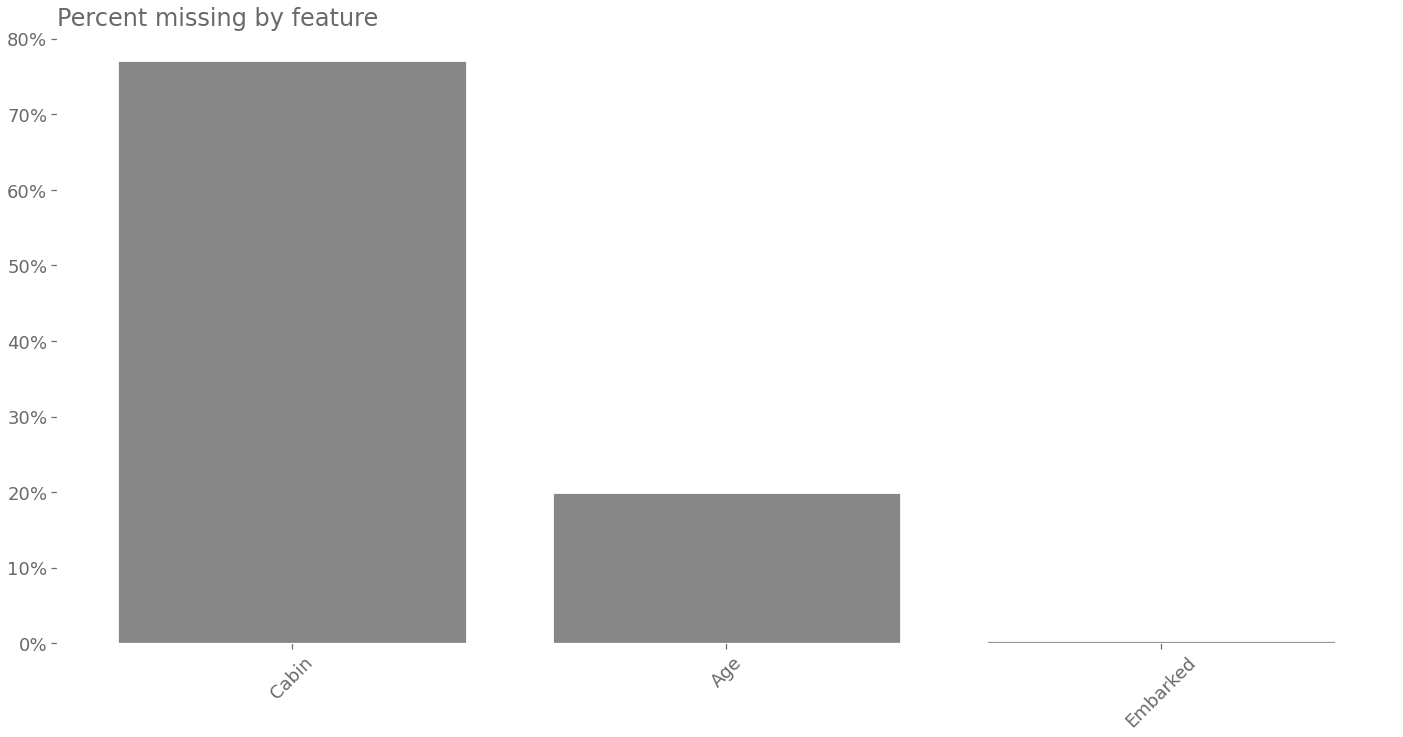

In [2]:
# generate missingness summary for training data
mlmachine_titanic_train.eda_missing_summary(display_df=True)

---
<br><br>
By default, this method acts on the `data` attribute associated with `mlmachine_train`. Let's do the same for the validation dataset:
<br><br>

,Total missing,Percent missing
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


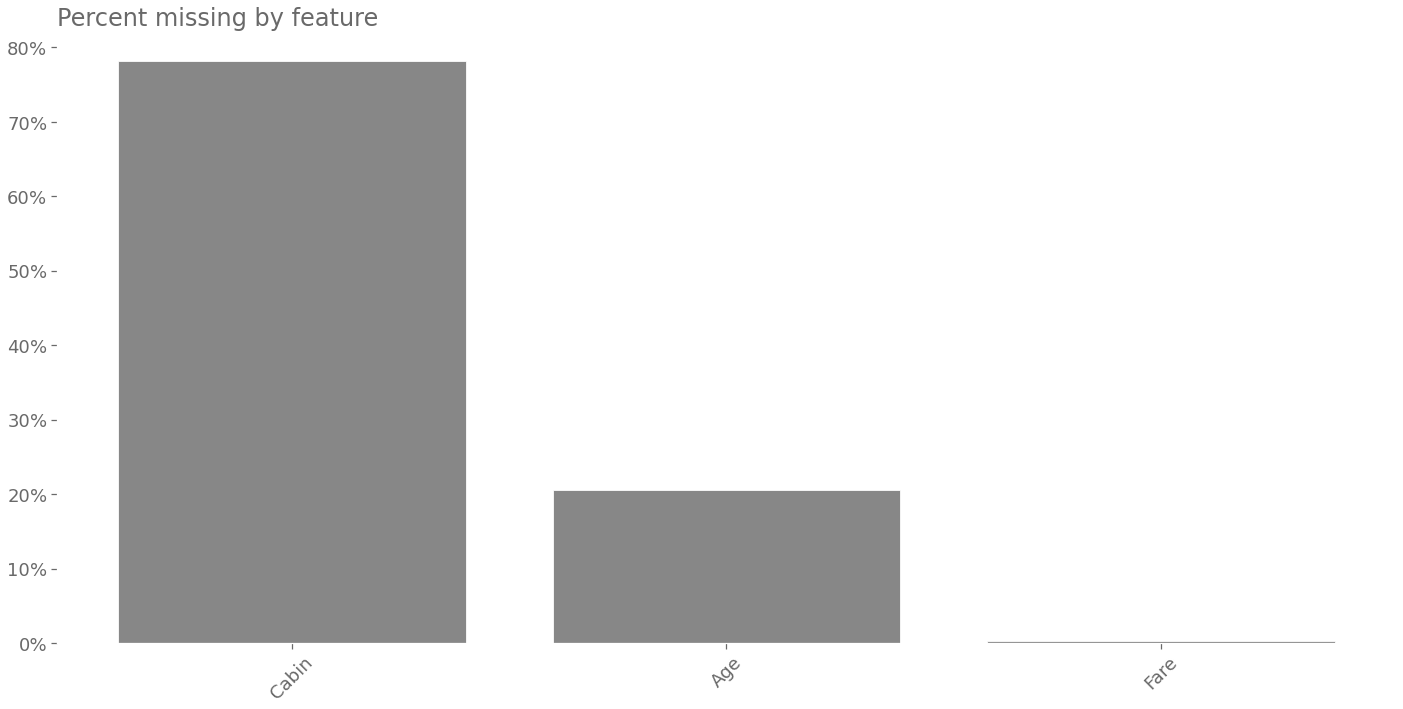

In [3]:
# generate missingness summary for validation data
mlmachine_titanic_valid.eda_missing_summary(display_df=True)

---
<br><br>
Next, we need to determine if there are features with missing values in the training data, but not the validation data, and vice versa. This informs how we should set up our transformation pipeline. For example, if a feature has missing values in the validation dataset, but not the training dataset, we will still want to fit_transform this feature on the training data to learn imputation values to apply on the nulls in the validation dataset.
<br><br>

We could eyeball the tables and visuals above to compare the state of missingness in the two datasets, but this can be tedious, particularly with large datasets. Instead, we will leverage a method within our `Machine()` object. We simply pass the validation dataset to `mlmachine_titanic_train`'s method `missing_col_compare`, which returns a bidirectional missingness summary.
<br><br>

In [4]:
# generate missingness comparison summary
mlmachine_titanic_train.missing_column_compare(
    validation_data=mlmachine_titanic_valid.data,
)

Feature has missing values in validation data, not training data.
{'Fare'}

Feature has missing values in training data, not validation data.
{'Embarked'}


---
<br><br>
The key observation here is that "Fare" is fully populated in the training data, but not the validation data. We need to make sure our pipeline learns how to impute these missing values based on the training data, despite the fact that the training data is not missing any values in this feature.
<br><br>

---
## GroupbyImputer
---
<br><br>
mlmachine includes a transformer called `GroupbyImputer()`, which makes it easy to perform the same basic imputation techniques provided by Scikit-learn's `SimpleImputer()`, but with the added ability to group by another feature in the dataset. Let's see an example:
<br><br>

<a id = 'GroupbyImputer'></a>

In [5]:
# import mlmachine tools
from mlmachine.features.preprocessing import GroupbyImputer

# instantiate GroupbyImputer to fill "Age" mean, grouped by "SibSp"
impute = GroupbyImputer(null_column="Age", groupby_column="SibSp", strategy="mean")
impute.fit_transform(mlmachine_titanic_train.data[["Age","SibSp"]])
display(impute.train_value)

,SibSp,Age
0,0,31.397558
1,1,30.089727
2,2,22.620000
3,3,13.916667
4,4,7.055556
5,5,10.200000


---
<br><br>
In the code snippet above, we mean impute "Age", grouped by "SibSp". We pass "Age" to the `null_column` parameter to indicate which column contains the nulls, and pass "SibSp" to the `groupby_column` parameter. The strategy parameter receives the same instructions as Scikit-learn's `SimpleImputer()` - "mean", "median" and "most_frequent".
<br><br>

To inspect the learned values, we can display the object's `train_value` attribute, which is a `DataFrame` containing the category/value pairs
<br><br>

`GroupbyImputer` uses these pairs to impute the missing values in "Age". If, in the unlikely circumstance, a level in `groupby_column` has only null values in `null_column`, then the missing values associated with that level will be imputed with the mean, median or mode of the entire feature.
<br><br>

---
## Imputation
---
<br><br>
Now we're going to use `GroupbyImputer()` within `PandasFeatureUnion()` to impute nulls in both the training and validation datasets.
<br><br>

<a id = 'Imputation'></a>

In [6]:
# import libraries
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# import mlmachine tools
from mlmachine.features.preprocessing import (
    DataFrameSelector,
    PandasTransformer,
    PandasFeatureUnion,
)

# create imputation PandasFeatureUnion pipeline
impute_pipe = PandasFeatureUnion([
    ("age", make_pipeline(
        DataFrameSelector(include_columns=["Age","SibSp"]),
        GroupbyImputer(null_column="Age", groupby_column="SibSp", strategy="mean")
    )),
    ("fare", make_pipeline(
        DataFrameSelector(include_columns=["Fare","Pclass"]),
        GroupbyImputer(null_column="Fare", groupby_column="Pclass", strategy="mean")
    )),
    ("embarked", make_pipeline(
        DataFrameSelector(include_columns=["Embarked"]),
        PandasTransformer(SimpleImputer(strategy="most_frequent"))
    )),
    ("cabin", make_pipeline(
        DataFrameSelector(include_columns=["Cabin"]),
        PandasTransformer(SimpleImputer(strategy="constant", fill_value="X"))
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=["Age","Fare","Embarked","Cabin"])
    )),
])

# fit and transform training data, transform validation data
mlmachine_titanic_train.data = impute_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = impute_pipe.transform(mlmachine_titanic_valid.data)

In [8]:
mlmachine_titanic_train.data[:20]

,Age,Fare,Embarked,Cabin,Parch,Pclass,Sex,SibSp
0,22.000000,7.2500,S,X,0,3,male,1
1,38.000000,71.2833,C,C85,0,1,female,1
2,26.000000,7.9250,S,X,0,3,female,0
3,35.000000,53.1000,S,C123,0,1,female,1
4,35.000000,8.0500,S,X,0,3,male,0
5,31.397558,8.4583,Q,X,0,3,male,0
6,54.000000,51.8625,S,E46,0,1,male,0
7,2.000000,21.0750,S,X,1,3,male,3
8,27.000000,11.1333,S,X,2,3,female,0
9,14.000000,30.0708,C,X,0,2,female,1


---
<br><br>
`GroupbyImputer()` makes two appearances in this `PandasFeatureUnion()` operation. On line 4, we groupby the feature "SibSp" to impute the mean "Age" value, and on line 8 we groupby the feature "Pclass" to impute the mean "Fare" value. 
<br><br>

Imputations for "Embarked" and "Cabin" are completed in straightforward fashion - "Embarked" is simply imputed with the mode, and "Cabin" is imputed with the constant value of "X".
<br><br>

Lastly, we `fit_transform()` the `PandasFeatureUnion()` on `mlmachine_titanic_train.data` and finish filling our nulls by calling `transform()` on `mlmachine_titanic_valid.data`.
<br><br>

---
# KFold Encoding - Exotic Encoding Without the Leakage
---
<br><br>
Target value-based encoding techniques such as mean encoding, CatBoost Encoding, and Weight of Evidence encoding are often discussed in the context of Kaggle competitions. The primary advantage of these techniques is that they use the target variable to inform the encoded feature's values. However, this comes with the risk of leaking target information into the encoded values. 
<br><br>

KFold cross-validation assists in avoiding this problem. The key is to apply the encoded values to the out-of-fold observations only. This visualization illustrates the general pattern:
<br><br>

<br><br>
![alt text](images/p3_kfold.jpeg "EDA Panel")
<br><br>

- Separate a validation subset from the training dataset.
- Learn the encoded values from the training data and the associated target values.
- Apply the learned values to the validation observations only.
- Repeat the process on the K-1 remaining folds.

<a id = 'KFold-Encoding-Exotic-Encoding-Without-the-Leakage'></a>

---
## KFoldEncoder
---
<br><br>
mlmachine has a class called `KFoldEncoder` that facilitates KFold encoding with an encoder of choice. Let's use a small subset of our features to see how this works. 
<br><br>

We want to target encode two features: "Pclass" and "Age". Since "Age" is a continuous feature, we first need to map the values to bins, which is effectively an ordinal categorical column. We handle all of this in the simple PandasFeatureUnion below:
<br><br>

<a id = 'KFoldEncoder'></a>

In [9]:
# import libraries
from sklearn.preprocessing import KBinsDiscretizer

# create simple encoding PandasFeatureUnion pipeline
encode_pipe = PandasFeatureUnion([
    ("bin", make_pipeline(
        DataFrameSelector(include_columns=["Age"]),
        PandasTransformer(KBinsDiscretizer(encode="ordinal"))
    )),
    ("select", make_pipeline(
        DataFrameSelector(include_columns=["Age","Pclass"])
    )),
])

# fit and transform training data, transform validation data
mlmachine_titanic_train.data = encode_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = encode_pipe.fit_transform(mlmachine_titanic_valid.data)

# update mlm_dtypes
mlmachine_titanic_train.update_dtypes()
mlmachine_titanic_valid.update_dtypes()

---
<br><br>
This operation returns a binned version of "Age", as well as the original "Age" and "Pclass" features.
<br><br>

In [10]:
mlmachine_titanic_train.data[:10]

,Age,Age_binned_5,Pclass
0,22.000000,1.0,3
1,38.000000,4.0,1
2,26.000000,1.0,3
3,35.000000,3.0,1
4,35.000000,3.0,3
5,31.397558,3.0,3
6,54.000000,4.0,1
7,2.000000,0.0,3
8,27.000000,1.0,3
9,14.000000,0.0,2


---
<br><br>
Next, we target encode both "Pclass" and "Age_binned_5" using mean encoding, CatBoost encoding and Weight of Evidence encoding as provided by the package category_encoders. 
<br><br>

We want to target encode two features: "Pclass" and "Age". Since "Age" is a continuous feature, we first need to map the values to bins, which is effectively an ordinal categorical column. We handle all of this in the simple PandasFeatureUnion below:
<br><br>

In [11]:
# import libraries
from sklearn.model_selection import KFold
from category_encoders import WOEEncoder, TargetEncoder, CatBoostEncoder

# import mlmachine tools
from mlmachine.features.preprocessing import KFoldEncoder

# create KFold encoding PandasFeatureUnion pipeline
target_encode_pipe = PandasFeatureUnion([
    ("target", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"], exclude_columns=["Cabin"]),        
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=True, random_state=0),
            encoder=TargetEncoder,
        ),
    )),
    ("woe", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=False),
            encoder=WOEEncoder,
        ),
    )),
    ("catboost", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=False),
            encoder=CatBoostEncoder,
        ),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["category"]),
    )),
])

# fit and transform training data, transform validation data
mlmachine_titanic_train.data = target_encode_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = target_encode_pipe.transform(mlmachine_titanic_valid.data)

# update mlm_dtypes
mlmachine_titanic_train.update_dtypes()
mlmachine_titanic_valid.update_dtypes()

In [12]:
mlmachine_titanic_train.data[:10]

,Age,Age_binned_5,Age_binned_5_catboost_encoded,Age_binned_5_target_encoded,Age_binned_5_woe_encoded,Pclass,Pclass_catboost_encoded,Pclass_target_encoded,Pclass_woe_encoded
0,22.000000,1.0,0.384154,0.408759,-0.051744,3,0.232625,0.261538,-0.774499
1,38.000000,4.0,0.415468,0.362416,0.077147,1,0.678008,0.611765,1.156363
2,26.000000,1.0,0.384154,0.359155,-0.051744,3,0.232625,0.230570,-0.774499
3,35.000000,3.0,0.333666,0.340426,-0.271806,1,0.678008,0.649425,1.156363
4,35.000000,3.0,0.333666,0.352332,-0.271806,3,0.232625,0.237852,-0.774499
5,31.397558,3.0,0.333666,0.343915,-0.271806,3,0.232625,0.252525,-0.774499
6,54.000000,4.0,0.415468,0.389610,0.077147,1,0.678008,0.649425,1.156363
7,2.000000,0.0,0.503105,0.470149,0.429123,3,0.232625,0.261538,-0.774499
8,27.000000,1.0,0.384154,0.350365,-0.051744,3,0.232625,0.252525,-0.774499
9,14.000000,0.0,0.503105,0.435714,0.429123,2,0.473186,0.471831,0.309629


---
<br><br>
Let's review the key `KFoldEncoder()` parameters:
- `target`: the target attribute of our mlmachine_titanic_train object
- `cv`: a cross-validation object
- `encoder`: a target encoder class
<br><br>

`KFoldEncoder()` learns the encoded values on the training data, and applies the values to the out-of-fold observations. 
<br><br>

On the validation data, the process is simpler: we calculate the average out-of-fold encodings applied to the training data and apply these values to all validation observations.
<br><br>

---
# Box, Cox, Yeo & Johnson - Skew Correctors
---

<a id = 'Box,-Cox,-Yeo-&-Johnson-Skew-Correctors'></a>

---
## Assessment
---
<br><br>
Just as we have a quick method for evaluating missingness, we have a quick method for evaluating skew.
<br><br>

<a id = 'Assessment-1'></a>

In [13]:
# generate skewness summary
mlmachine_titanic_train.skew_summary()

,Skew,Percent zero
Age,0.378296,0.0
Pclass_woe_encoded,0.440739,0.0
Pclass_target_encoded,0.486805,0.0
Pclass_catboost_encoded,0.488195,0.0
Age_binned_5_woe_encoded,0.896280,0.0
Age_binned_5_target_encoded,0.907149,0.0
Age_binned_5_catboost_encoded,1.013313,0.0


---
<br><br>
The `skew_summary()` method returns a `DataFrame` that summarizes the skew for each feature, along with a "Percent zero" column, which informs us of the percentage of values in the feature that are zero.
<br><br>

---
## Skew correction
---
<br><br>
mlmachine contains a class called `DualTransformer()`, which, by default, applies both Yeo-Johnson and Box-Cox transformations to the specified features with the intent of correcting skew. The Box-Cox transformation automatically seeks the lambda value which maximizes the log-likelihood function. 
<br><br>

Since Box-Cox transformation requires all values in a feature to be greater than zero, `DualTransformer()` applies one of two simple feature adjustments when this rule is violated:
<br><br>
- If the minimum value in a feature is zero, each value in that feature is increased by a value of 1 prior to transformation. 
- If the minimum value is less than zero, then each feature value is increased by the absolute value of the minimum value in the feature plus 1 prior to transformation.
<br><br>

Let's use `DualTransformer()` to see if we can minimize the skew in the original "Age" feature:
<br><br>

<a id = 'Skew-correction'></a>

In [14]:
# import mlmachine tools
from mlmachine.features.preprocessing import DualTransformer

# create skew correction PandasFeatureUnion pipeline
skew_pipe = PandasFeatureUnion([
    ("skew", make_pipeline(
        DataFrameSelector(include_columns=["Age"]),
        DualTransformer(),
    )),    
])

# fit and transform training data, transform validation data
mlmachine_titanic_train.data = skew_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = skew_pipe.transform(mlmachine_titanic_valid.data)

# update mlm_dtypes
mlmachine_titanic_train.update_dtypes()
mlmachine_titanic_valid.update_dtypes()

In [15]:
mlmachine_titanic_train.data[:10]

,Age,Age_BoxCox,Age_YeoJohnson
0,22.000000,14.647411,15.214763
1,38.000000,23.820753,24.307202
2,26.000000,17.021366,17.565451
3,35.000000,22.159041,22.658670
4,35.000000,22.159041,22.658670
5,31.397558,20.132241,20.648647
6,54.000000,32.360674,32.784933
7,2.000000,0.939022,1.799315
8,27.000000,17.605151,18.143830
9,14.000000,9.662922,10.289229


---
<br><br>
`DualTransformer()` adds the features "Age_BoxCox" and "Age_YeoJohnson". Let's execute `skew_summary()` again to see if `DualTransformer()` addressed the skew in our original feature:
<br><br>
"Age_BoxCox" and "Age_YeoJohnson" have a skew of 0.0286 and 0.0483, respectively.
<br><br>

In [16]:
# generate skewness summary
mlmachine_titanic_train.skew_summary()

,Skew,Percent zero
Age_BoxCox,0.028608,0.007856
Age_YeoJohnson,0.048311,0.000000
Age,0.378296,0.000000


---
<br><br>
Star the [GitHub repository](https://github.com/petersontylerd/mlmachine), and stay tuned for additional notebooks.
<br><br>